*updated 11 Aug 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 4303 "AI and Machine Learning in Marine Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES4303_ML_ocean) page.

---
# 7. Random forests and gradient boosting

### TL;DR: Basically just ***ensembles*** of decision trees.

<img src="https://i.imgur.com/vlEyC0x.jpeg" width="500" alt='forests of randoms'>

In that sense this notebook is going to reasonably short and focus more on the technicalities and details. I am only going to do the classification problem; the regression problem and extended investigation is left as an exercise.

> ## Key Objective(s)
> 1. Elaborate on the benefits of using an ensemble of decision trees.
> 2. Provide the distinctions between the two ensemble methods based around decision trees.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

loading data remotely


---
## a) Random forests

The idea here is that a single decision tree is prone to over-fitting, and the structure of the tree itself can demonstrate quite a bit of variability in the eventual classification / regression depending on initialisation and/or choice of data. One way to get around this is to train up a collection of trees (i.e. a "forest") and take a (possibly weighted) average of the decisions, and call that final product your classifer / regressor. Because of the aveaging operation you might suspect the resulting model to be more robust and less prone to over-fitting.

The way this roughly works is as follows the pictorial below (with exaggerations):

<img src="https://i.imgur.com/bOy1l4N.jpeg" width="1200" alt='schematic'>

### 1) Bootstrap sampling

In your training set you create sub-samples of the training data via ***bootstrap sampling***, a bit like when you did $K$-fold cross-validation. The difference here is you allow for replacement of data. As an example, if the whole dataset is $[a, b, c, d, e]$ and I allow sampling four of these to form one of my sub-training sets, then the following are permissiable under bootstrap sampling but not in $K$-fold splitting:

* $[a, b, a, c]$
* $[a, b, b, a]$
* $[a, a, a, a]$

Note that $[a, e, c, d]$ would be permissable under both with and without replacement sampling.

> <span style="color:red">Q.</span> In reality if you were doing $K$-folds you probably wouldn't get $[a, e, c, d]$ as one of the folds anyway, why is that?

### 2) Bagging (or boostrap aggregation)

***Bagging*** is just you training models based on the dataset obtained from bootstrap aggregation like in the above. The ***random*** part in the "random forest" comes from the fact that the bootstrap sampling is going to introduce randomness in the created models.

Note the ensemble members are in general going to be weak learners, becasue the exposed sub-sample datasize will likely be low. The idea is that you have multiple weak learners that aggregate into a robust stronger learner. See the [original paper](https://link.springer.com/article/10.1023/A:1018054314350) for why this should work.

### 3) Averaging / voting

Once you have the ensemble members, then when you use the ensemble to make a prediction, all of the members make a prediction, and the result is averaged for a regressor, or a majority vote is taken for a classifer.

Note because this is an ensemble method, some measures of probability in the predictions are in principle given.

> NOTE: The things described above can in principle be applied to other methods (e.g. linear models, neural networks), although it is most commonly used with decision trees.
>
> In `sklearn` the averaging and voting is simple in that the weights are uniform (no biases). You also only get votes (as a probability) in the classifier. Could in principle bully the code to deal with uneven weights, but this is not demonstrated here.

Below code demonstrates the usage of random forests with the penguin data, first using the `RandomForestClassifer` object. I am deliberately forcing the resulting trees to be shallow. with `max_depth=2`, and I create 20 trees here (`n_estimators=20`).

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.inspection import DecisionBoundaryDisplay

# aim: predict species from features (exactly as in trees basically)
feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[feature_names].values

# turn target from text to numerical values
encoder = LabelEncoder()
Y = encoder.fit_transform(df["species"])

# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# use an ensemble of 20 trees (but same max_depth and criterion as before)
model = RandomForestClassifier(max_depth=2, n_estimators=20, criterion="entropy",
                              random_state=4167)
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")

overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.3102
    bill_depth_mm        = 0.2054
    flipper_length_mm    = 0.4550
    body_mass_g          = 0.0294


Note in contrast to the decision tree example in the previous lecture, when I specify `max_depth=2` I end up not using the `body_mass_g` feature. Here the feature importance shows up as a non-zero (but small) value, indicating that some of the ensemble members did pick that feature up to do segmentation on.

We can visualise some of the ensemble members below.

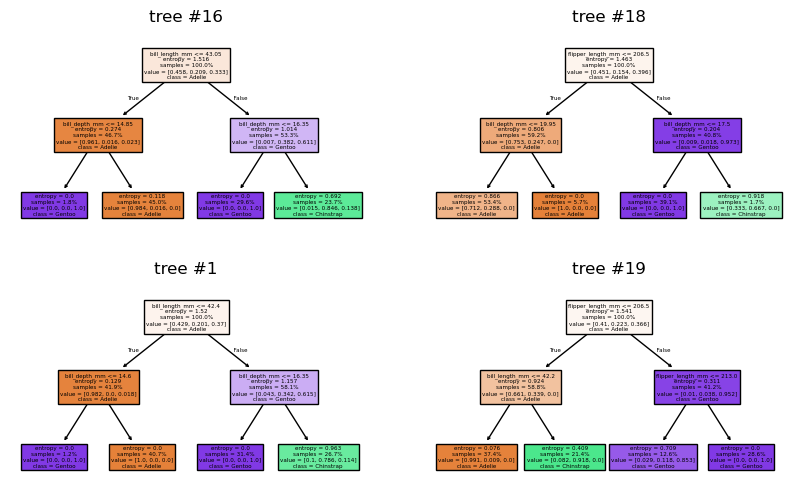

In [3]:
# visualise some of trees

# randomly choose 4 of the "n_estimators" to plot
inds = np.arange(20)
np.random.shuffle(inds)
ind = inds[:4]  # pick out the first four

fig = plt.figure(figsize=(10, 6))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plot_tree(model.estimators_[ind[i]], filled=True, proportion=True, ax=ax,
             feature_names=feature_names, class_names=encoder.classes_)
    ax.set_title(f"tree #{ind[i]}")

The `RandomForestClassifier` object comes with probability measures that we can probe, using `model.predict_proba()`. `X_test` should be the input in this case, and the outputs are the probabilities over the ensemble (of size `n_estimators`) of predicting class `0`, `1` or `2` (corresponding to `Adelie`, `Chinstrap` and `Gentoo`).

In the below I plot the probabilities, and the classifier returns the predicted label associated with the largest probability. I also label the actual labels by the bars with the brightest bar. Notice then the tallest bars do not correspond to the brightest, i.e. a wrong classification, although it is mostly the case. This observation is consistent with the summary statistics above.

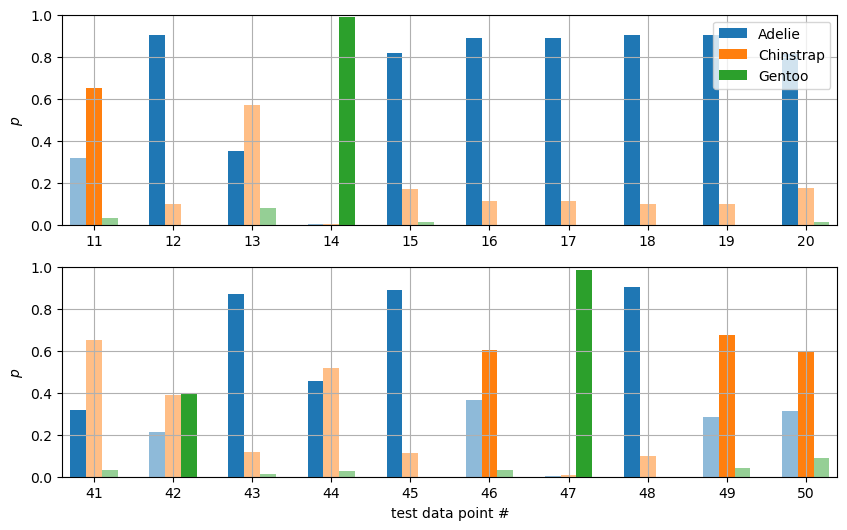

In [4]:
probs = model.predict_proba(X_test)
x = np.arange(len(Y_test))
width = 0.2

fig = plt.figure(figsize=(10, 6))

ax = plt.subplot(2, 1, 1)

# do a quick plot for legend purposes but never actually show it
x_temp = -10
for j in range(3):
    ax.bar(x_temp+(j-1)*width, probs[0, j], width=width, color=f"C{j}",
           label=f"{encoder.classes_[j]}")

for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([10.6, 20.4])
ax.set_ylim([0, 1])
ax.set_ylabel(r"$p$")
ax.grid()
ax.legend()

ax = plt.subplot(2, 1, 2)
for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([40.6, 50.4])
ax.set_ylim([0, 1])
ax.set_xlabel("test data point #")
ax.set_ylabel(r"$p$")
ax.grid();

### Out-Of-Bag score

This is a measure of how we might expect the models to generalise to new data. First, ***out-of-bag*** is the complement of the bagged samples: following example above, if your whole dataset is $[a,b,c,d,e]$, and the bagging gives a subset of $[a, c, b, a]$, then the out-of-bag part is
\begin{equation*}
    \mbox{OOB} = [a,b,c,d,e] \setminus [a,c,b,a] = [a,b,c,d,e] - [a,b,c] = [d, e],
\end{equation*}
where $\setminus$ is to mean be a set operation and ignoring duplicates.

The out-of-bag score is then the average skill of the ensemble members in predicting things out-of-bag. To enable this metric we pass `oob_score=True` in (it is `False` by default because then you do fewer calculations). A value of 1 means the members all predicted with 100% accuracy, and a value closer to 1 would suggest models are likely going to generalise better to unseen data.

In [5]:
# use an ensemble of 20 trees (but same max_depth and criterion as before)
model = RandomForestClassifier(max_depth=2, n_estimators=20, criterion="entropy",
                              random_state=4167, oob_score=True)
model.fit(X_train, Y_train)
print(f"model OOB accuracy = {model.oob_score_*100:.4f}%")
print(" ")

model OOB accuracy = 93.0403%
 


> <span style="color:red">Q.</span> For me the problematic test set data seems to be at index 13, 41 and 42. Have a look and those associated data points and see if there is a reason they are particularly hard for the prediction step (e.g. are they in a region that is particularly "mixed"?)
> 
> <span style="color:red">Q.</span> Try some of the above for `RandomForestRegressor`, e.g. do the prediction problem I did last time. The only thing you don't have access to are the probabilities of the predictions (the returned value is an average of all ensemble members).
>
> <span style="color:red">Q.</span> Consider changing other things such as pruning parameter `ccp_alpha`, `max_depth`, `min_samples_leaf`, `criterion` and see how performance differs. Could also do cross-validation and hyper-parameter tuning accordingly.

---
## b) Gradient boosting

The idea of ensemble methods is that you train a whole load of weak models, but the variance of the models are reduced through some sort of averaging procedure, leading to ensemble predictions that are more robust, but it may or may not say anything about the bias. The idea of ***boosting*** is to target the bias by targeting the problematic predictions, and considers the following pipeline:

1. Train an ensemble of models again, and identify the particularly weak models, i.e. the ones that got misclassified or had particularly large prediction errors.
2. Take those biases and compute residuals/mismatches/losses, change the weighting of the DATA to improve those particularly weak models, with the aim to "boost" the performance of the overall ensemble.
5. Re-train the model, repeat the processing of weight updates, and iterate until you get some convergence of the overall ensemble.

In that sense it's an optimisation problem (again!), hence my usage of familiar terms. The ***gradient*** part is that it uses (stochastic) gradient descent type methods to solve the optimisation problem associated with ***boosting***.

The demonstration below applies `GradientBoostingClassifier` to the same problem as above.

In [6]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# use an ensemble of 20 trees (but same max_depth and criterion as before)
model = GradientBoostingClassifier(max_depth=2, n_estimators=20,
                                   random_state=4167)
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(f"fitted feature importance [1 = max]:")
for i in range(len(feature_names)):
    print(f"    {feature_names[i]:<20} = {model.feature_importances_[i]:.4f}")
print(" ")

overall skill: 65 correct out of 69 (94.20%)
fitted feature importance [1 = max]:
    bill_length_mm       = 0.4111
    bill_depth_mm        = 0.0780
    flipper_length_mm    = 0.4415
    body_mass_g          = 0.0693
 


So in this case with exactly the basically the same settings as the `RandomForestClassifer` the skill on the test set is comparable to the random forests. What is slightly different are the associated probabilities in the resulting trees.

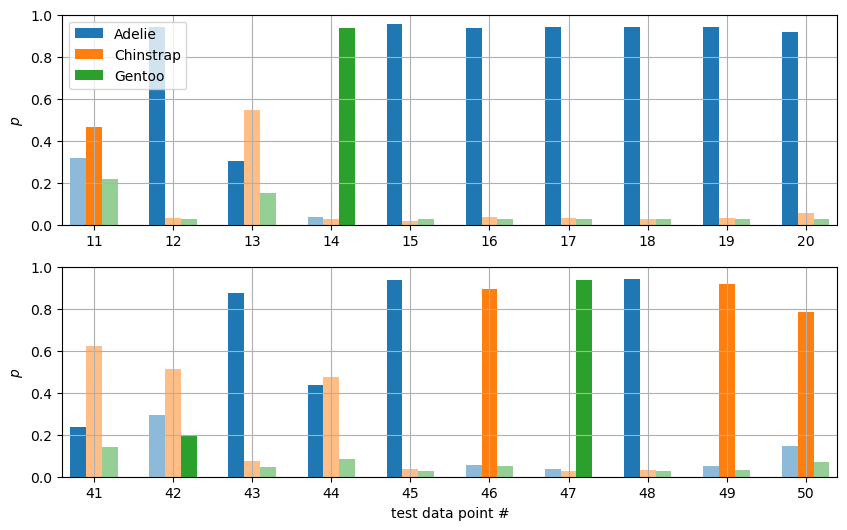

In [7]:
# plot the associated probabilities
probs = model.predict_proba(X_test)
x = np.arange(len(Y_test))
width = 0.2

fig = plt.figure(figsize=(10, 6))

ax = plt.subplot(2, 1, 1)

# do a quick plot for legend purposes but never actually show it
x_temp = -10
for j in range(3):
    ax.bar(x_temp+(j-1)*width, probs[0, j], width=width, color=f"C{j}",
           label=f"{encoder.classes_[j]}")

for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([10.6, 20.4])
ax.set_ylim([0, 1])
ax.set_ylabel(r"$p$")
ax.grid()
ax.legend()

ax = plt.subplot(2, 1, 2)
for i in range(len(Y_test)):
    x_temp = x[i]
    truth = Y_test[i]
    for j in range(3):
        if j == truth:
            alpha=1.0
        else:
            alpha=0.5
        ax.bar(x_temp+(j-1)*width, probs[i, j], width=width, alpha=alpha,
               color=f"C{j}")
ax.set_xticks(x)
ax.set_xlim([40.6, 50.4])
ax.set_ylim([0, 1])
ax.set_xlabel("test data point #")
ax.set_ylabel(r"$p$")
ax.grid();

The thing that is probably true in this case is that where the bars were already tall in the random forest case it is even taller here.

Interestingly, both classifers are failing at the same prediction points (for me it's index 13, 41 and 42). It is perhaps of interest to have a look at what is going on there.

> <span style="color:red">Q.</span> For me the problematic test set data seems to be at index 13, 41 and 42. Have a look and those associated data points and see if there is a reason they are particularly hard for the prediction step (e.g. are they in a region that is particularly "mixed"?)
> 
> <span style="color:red">Q.</span> Try some of the above for `GradientBoostingRegressor`, e.g. do the prediction problem I did last time. The only thing you don't have access to are the probabilities of the predictions (the returned value is an average of all ensemble members).
>
> <span style="color:red">Q.</span> Consider changing other things such as pruning parameter `ccp_alpha`, `max_depth`, `min_samples_leaf`, `criterion` and see how performance differs. Could also do cross-validation and hyper-parameter tuning accordingly.

----------------
# More involved exercises with this notebook

## 1) Regression problems

As indicated already. 

There might be something to be said about doing an even simpler regression problem (e.g. $f(x) = \sin x + \epsilon$) and visualising how that works, particularly for gradient boosting as the iterations progress (if possible).

## 2) Image classification and/or extrapolation

This is a hard problem. Going to the raw images of cats and/or dogs, consider training 

1. Classifiers for cats and dogs,
2. Regressors on half the face and using it to predict the other half. Analyse the skill on training data, testing data, the need for standardising the data, analysis of the model coefficients, dependence on the propotion of face exposed to model, cross-validation and etc.

From a coding point of view it is potentially easier to use the left half of the face to predict the right half (idea below). You can try top and bottom also.

Just be aware if you use the full image it might be slow (I never managed to get `GradientBoostingRegressor` to converge for the regression problem, although you could try `HistGradientBoostingRegressor` instead). You may or may not want to do dimension reduction on these first, which will probably help speed up the classification problem quite a bit; not sure about the regression problem.

## 3) Time series forecasting

Consider regression on time series data like `elnino34_sst.data`, Lotka-Volterra, Lorenz, or similar.